## Overturning 

This notebook for comapring overturning in sigma vs z space. 

In [88]:
import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask

In [131]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    
    ax.add_feature(cfeature.LAND) #, zorder=100, edgecolor='k') #, facecolor='black')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    
    return fig, cb 

In [69]:
ppdir_z = "/gws/nopw/j04/snapdragon/hkhatri/Data_Consolidated/"
ppdir_sigma =  "/gws/nopw/j04/snapdragon/hkhatri/Data_sigma/Transport_sigma/Regridded/"

ds_z = []
ds_sigma = []

for year in range(1960, 1963):
    
    d = xr.open_dataset(ppdir_z + str(year) +"_diaptr.nc", chunks = {'time_counter':1})
    ds_z.append(d.zomsfatl.drop(['time_counter', 'time_centered']))

    ds1 = []
    for r in range(1,11):
        
        d = xr.open_dataset(ppdir_sigma + "Transport_sigma_" + str(year) + "_r" + str(r) + ".nc", chunks = {'time':1})
    
        ds1.append(d.drop('time'))
        
    ds1 = xr.concat(ds1, dim='r')
    ds_sigma.append(ds1)
        
ds_z = xr.concat(ds_z, dim='year')
ds_z = ds_z.rename({'time_counter':'time'})

ds_sigma = xr.concat(ds_sigma, dim='year')

In [70]:
print(ds_z, ds_sigma)

<xarray.DataArray 'zomsfatl' (year: 3, r: 10, time: 125, depthw: 75, y: 451,
                              x: 1)>
dask.array<concatenate, shape=(3, 10, 125, 75, 451, 1), dtype=float32, chunksize=(1, 10, 1, 75, 451, 1), chunktype=numpy.ndarray>
Coordinates:
  * depthw   (depthw) float32 0.0 1.024 2.103 ... 5.393e+03 5.596e+03 5.8e+03
    nav_lat  (y, x) float32 3.997 4.246 4.495 4.745 ... 79.78 79.85 79.92 79.99
    nav_lon  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: year, r, time, y, x
Attributes:
    standard_name:       meridional_streamfunction_atlantic
    long_name:           Meridional Stream-Function: Atlantic
    units:               Sv
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 900 s) <xarray.Dataset>
Dimensions:            (year: 3, r: 10, time: 125, sigma0: 48, lat: 134,
                        lon: 200, sigma0_bnds: 49,

In [71]:
%time tmp_z = ds_z.isel(year=0).mean(['time', 'r']).assign_coords(y=ds_z.nav_lat.isel(x=0)).compute()

%time tmp_sigma = ds_sigma['psi_sigma'].isel(year=0).mean(['time', 'r']).compute()

CPU times: user 660 ms, sys: 273 ms, total: 933 ms
Wall time: 386 ms
CPU times: user 2.49 s, sys: 741 ms, total: 3.23 s
Wall time: 5.43 s


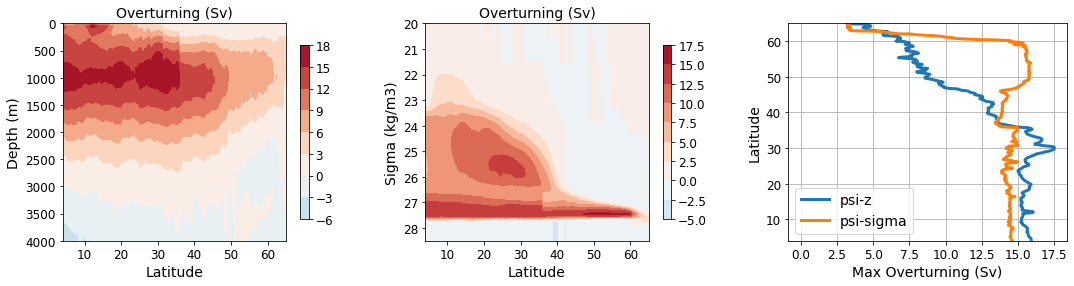

In [72]:
grid1 = plt.GridSpec(1, 3, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid1[0, 0])

#tmp = ds_z.isel(year=0, r=0).mean('time').assign_coords(y=ds_z.nav_lat.isel(x=0)).compute()

#p = tmp_z.plot(ax=ax, x='nav_lat', y='depthw', vmin=-20, vmax=20, levels=39,
#                 cmap='RdBu_r', add_labels=False)
p = ax.contourf(tmp_z.nav_lat, tmp_z.depthw, tmp_z.isel(x=0), vmin=-20., vmax=20., cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([0., 4000.])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[0, 1])
p = ax.contourf(tmp_sigma['j_c'], tmp_sigma.sigma0, tmp_sigma/1e6, vmin=-20., vmax=20., cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Sigma (kg/m3)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([20., 28.5])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[0, 2])
ax.plot(tmp_z.isel(x=0).max('depthw'), tmp_z.nav_lat, lw=3, label='psi-z')
ax.plot(tmp_sigma.max('sigma0')/1e6, tmp_sigma['j_c'], lw=3, label='psi-sigma')
plt.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([4., 65.])
ax.set_ylabel('Latitude', fontsize=14)
ax.set_xlabel('Max Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

In [121]:
%time tmp_v = ds_sigma['v_transport_sigma'].isel(year=0, sigma0=34).mean(['time', 'r']).compute()
%time tmp_thick = ((ds_sigma['depth_sigma'].isel(year=0, sigma0_bnds=35) - ds_sigma['depth_sigma'].isel(year=0, sigma0_bnds=34)).mean(['time', 'r']).compute())

CPU times: user 2.47 s, sys: 3.37 s, total: 5.85 s
Wall time: 16.3 s
CPU times: user 3.02 s, sys: 3.12 s, total: 6.14 s
Wall time: 4.21 s


/tmp/ipykernel_611/3174417348.py:8: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"


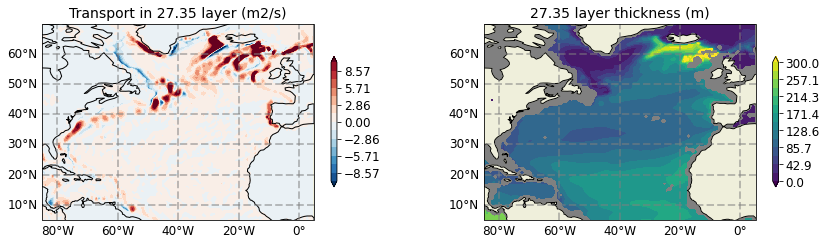

In [134]:
lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(1, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[14, 4])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')

[p, cb] = plot_sec(ax, tmp_v, vmin=-10., vmax=10.,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='lon', lat='lat', cmap='RdBu_r', title='Transport in 27.35 layer (m2/s)')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp_thick, vmin=0., vmax=300., lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='lon', lat='lat', cmap='viridis', title='27.35 layer thickness (m)')

In [111]:
ds_sigma.sigma0[34]

<xarray.DataArray 'sigma0' ()>
array(27.35)
Coordinates:
    sigma0   float64 27.35